<a href="https://colab.research.google.com/github/nour-said/Movie_recommender_system/blob/main/MRS_intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from termcolor import colored

In [46]:
# Load MovieLens 100K dataset (u.data + u.item)
ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
movies = pd.read_csv("u.item", sep="|", encoding="latin-1", header=None, usecols=[0,1], names=["item_id", "title"])

# Merge
ratings = pd.merge(ratings, movies, on="item_id")

print(" Dataset Loaded")
print(ratings.head())


 Dataset Loaded
   user_id  item_id  rating  timestamp                       title
0      196      242       3  881250949                Kolya (1996)
1      186      302       3  891717742    L.A. Confidential (1997)
2       22      377       1  878887116         Heavyweights (1994)
3      244       51       2  880606923  Legends of the Fall (1994)
4      166      346       1  886397596         Jackie Brown (1997)


In [47]:
# Pivot table (users × movies)
user_item_matrix = ratings.pivot_table(index="user_id", columns="title", values="rating")

print(" User-Item Matrix created")
print(user_item_matrix.shape)

 User-Item Matrix created
(943, 1664)


In [49]:
# Keep NaNs in user_item_matrix
user_item_matrix = ratings.pivot_table(index='user_id', columns='title', values='rating')

# For cosine similarity, fill NaN with 0 (just for similarity calculation)
item_item_matrix = user_item_matrix.fillna(0).T

item_similarity = pd.DataFrame(
    cosine_similarity(item_item_matrix),
    index=item_item_matrix.index,
    columns=item_item_matrix.index
)

def recommend_movies_item_based(user_id, n=5):
    # Get movies that the user has rated
    user_ratings = user_item_matrix.loc[user_id].dropna()
    scores = pd.Series(dtype=float)

    for movie, rating in user_ratings.items():
        # Weight similarity by user rating
        similar_scores = item_similarity[movie] * rating
        scores = scores.add(similar_scores, fill_value=0)

    # Remove already seen movies
    scores = scores.drop(user_ratings.index, errors="ignore")

    # Return top-n recommendations
    return scores.sort_values(ascending=False).head(n)


In [50]:
# Replace NaN with 0
matrix = user_item_matrix.fillna(0)

# SVD
svd = TruncatedSVD(n_components=20)
matrix_svd = svd.fit_transform(matrix)

# Reconstructed ratings
pred_matrix = np.dot(matrix_svd, svd.components_)
pred_ratings = pd.DataFrame(pred_matrix, index=matrix.index, columns=matrix.columns)

def recommend_movies_svd(user_id, n=5):
    user_ratings = user_item_matrix.loc[user_id].dropna()
    preds = pred_ratings.loc[user_id].drop(user_ratings.index, errors="ignore")
    return preds.sort_values(ascending=False).head(n)


In [51]:
def precision_at_k(recommended, actual, k=5):
    recommended_k = recommended.index[:k]
    hits = len(set(recommended_k).intersection(set(actual)))
    return hits / k

def get_actual_likes(user_id, threshold=4):
    return ratings[(ratings["user_id"] == user_id) & (ratings["rating"] >= threshold)]["title"].tolist()


In [54]:
from sklearn.model_selection import train_test_split

print(" Step 6: Evaluation")

# --- Split ratings into train/test ---
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Rebuild user-item matrix only from TRAIN
user_item_matrix = train.pivot_table(index='user_id', columns='title', values='rating')

# Rebuild similarity with train data
item_item_matrix = user_item_matrix.fillna(0).T
item_similarity = pd.DataFrame(
    cosine_similarity(item_item_matrix),
    index=item_item_matrix.index,
    columns=item_item_matrix.index
)

# --- Functions ---
def get_actual_likes(user_id, threshold=4):
    """Movies the user rated highly in the TEST set (hidden)."""
    return test[(test['user_id'] == user_id) & (test['rating'] >= threshold)]['title'].tolist()

def precision_at_k(recommended, actual, k=5):
    recommended_k = recommended.index[:k]
    hits = len(set(recommended_k).intersection(set(actual)))
    return hits / k if k > 0 else 0

# --- Evaluation for all users ---
all_users = user_item_matrix.index.tolist()
results = []

for u in all_users:
    actual_likes = get_actual_likes(u, threshold=4)
    if len(actual_likes) == 0:
        continue

    rec_item = recommend_movies_item_based(u, 5)
    rec_svd = recommend_movies_svd(u, 5)

    prec_item = precision_at_k(rec_item, actual_likes, k=5)
    prec_svd = precision_at_k(rec_svd, actual_likes, k=5)

    results.append((prec_item, prec_svd))

results_df = pd.DataFrame(results, columns=["Item-based P@5", "SVD P@5"])

print("\n📊 Average Precision@5:")
print(f"Item-based CF = {results_df['Item-based P@5'].mean():.3f}")
print(f"SVD = {results_df['SVD P@5'].mean():.3f}")

# --- Interactive user test ---
user_id = int(input("\n🔹 Enter a User ID (1–943): "))

actual_likes = get_actual_likes(user_id, threshold=4)
print(f"\n--> User {user_id} actually liked:")
print(actual_likes)

rec_item = recommend_movies_item_based(user_id, 5)
rec_svd = recommend_movies_svd(user_id, 5)

print("\n📌 Item-based CF Recommendations:")
print(list(rec_item.index))

print("\n📌 SVD Recommendations:")
print(list(rec_svd.index))


 Step 6: Evaluation

📊 Average Precision@5:
Item-based CF = 0.266
SVD = 0.449

🔹 Enter a User ID (1–943): 45

--> User 45 actually liked:
['Blue in the Face (1995)', 'Godfather, The (1972)', 'That Thing You Do! (1996)', 'Men in Black (1997)']

📌 Item-based CF Recommendations:
['Mission: Impossible (1996)', 'Rock, The (1996)', 'Star Trek: First Contact (1996)', 'Twelve Monkeys (1995)', 'Phenomenon (1996)']

📌 SVD Recommendations:
['Rock, The (1996)', 'Godfather, The (1972)', 'Men in Black (1997)', 'Mission: Impossible (1996)', 'Twelve Monkeys (1995)']


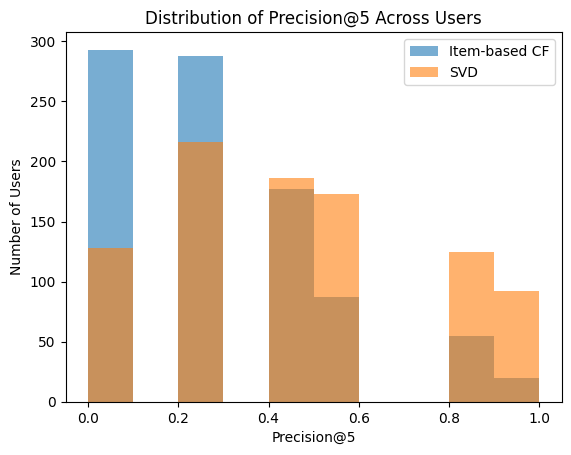

In [57]:
import matplotlib.pyplot as plt
plt.hist(results_df["Item-based P@5"], alpha=0.6, label="Item-based CF", bins=10)
plt.hist(results_df["SVD P@5"], alpha=0.6, label="SVD", bins=10)
plt.title("Distribution of Precision@5 Across Users")
plt.xlabel("Precision@5")
plt.ylabel("Number of Users")
plt.legend()
plt.show()
